In [1]:
import pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt, numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import rc

In [2]:
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

In [3]:
data = pd.read_csv('data.csv')

data = data.rename(columns={'Last Updated' : 'LastSeen'})
data.columns = data.columns.str.replace(' ','')

data.loc[10472, 'AndroidVer'] = data.loc[10472, 'CurrentVer']
data.loc[10472, 'CurrentVer'] = data.loc[10472, 'LastSeen']
data.loc[10472, 'LastSeen'] = data.loc[10472, 'Genres']
data.loc[10472, 'Genres'] = None

data.loc[:,'LastSeen'] = pd.to_datetime(data.loc[:,'LastSeen'])


In [4]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastSeen,CurrentVer,AndroidVer
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In [5]:
test_series = pd.Series(data.App.values, index=data.LastSeen.values)
test_series.index = test_series.index.to_period('M')
test_grp = test_series.groupby(test_series.index).count()

In [6]:
train_data = test_grp[test_grp.index < '2017-03']
train_data.index = train_data.index.to_timestamp()

test_data = test_grp[test_grp.index >= '2017-03']
test_data.index = test_data.index.to_timestamp()

print('Train Data : {}\nTest Data : {}'.format(len(train_data), len(test_data)))

Train Data : 70
Test Data : 18


In [7]:
train_data_logs = np.log(train_data)

train_data_shift = train_data_logs - train_data_logs.shift(1)

print(sm.tsa.adfuller(train_data))
print( sm.tsa.adfuller(train_data_shift[1:]) )

model = sm.tsa.ARIMA(train_data_logs, order=(3,1,3)).fit(disp=-1)

(4.960390074208158, 1.0, 3, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 407.4749020013717)
(-6.447895417808779, 1.5494118101738177e-08, 2, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 66.91936784813025)


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


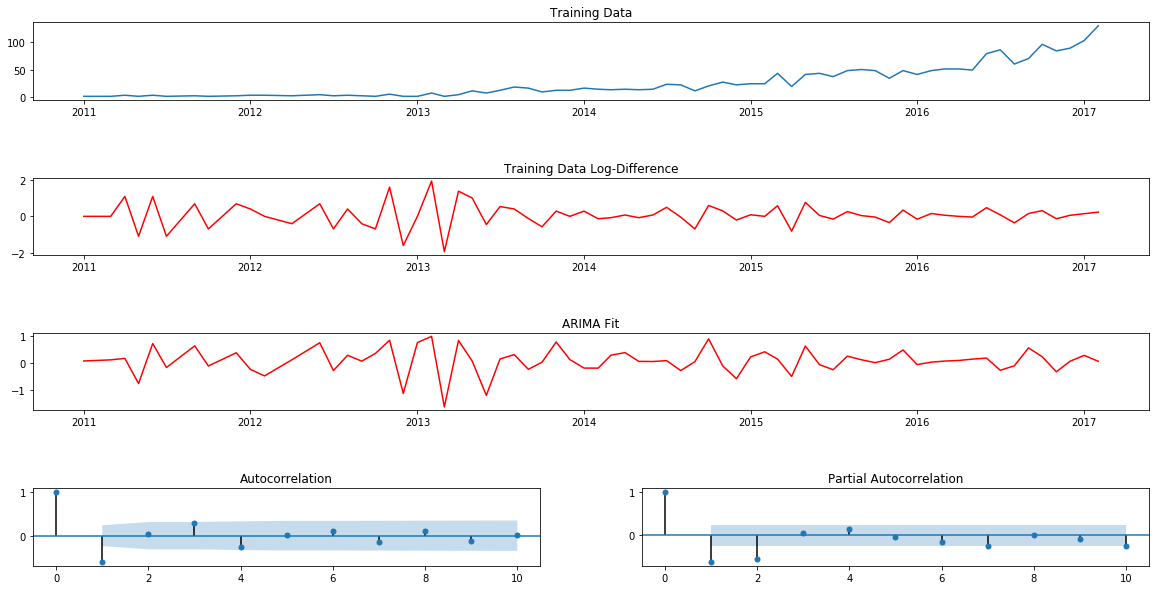

In [8]:
fig3 = plt.figure(figsize=(20,10))
gs = fig3.add_gridspec(4, 2, hspace=1)
f3_ax1 = fig3.add_subplot(gs[0, :], title='Training Data')
f3_ax2 = fig3.add_subplot(gs[1, :], title='Training Data Log-Difference')
f3_ax3 = fig3.add_subplot(gs[2, :], title='ARIMA Fit')
f3_ax4 = fig3.add_subplot(gs[3, 0])
f3_ax5 = fig3.add_subplot(gs[3, 1])
f3_ax1.plot(train_data[1:])
f3_ax2.plot(train_data_shift[1:], color='r')
f3_ax3.plot(model.fittedvalues, color='r')
x = plot_acf(train_data_shift[1:], ax=f3_ax4, lags=10)
y = plot_pacf(train_data_shift[1:], ax=f3_ax5, lags=10)


In [9]:
model.aic

96.67396265820281

In [10]:
predictions_diff = model.fittedvalues

In [11]:
predictions_diff_cumsum = predictions_diff.cumsum()

In [12]:
predictions_diff_log = pd.Series(train_data_logs.iloc[0], index=train_data_logs.index)

In [13]:
predictions_diff_log = predictions_diff_log[1:].add(predictions_diff_cumsum.values)

In [14]:
len(predictions_diff)

69

In [15]:
predictions_ARIMA = np.exp(predictions_diff_log)

In [16]:
model.predict(train_data.shape[0], train_data.shape[0]+17)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


69   -0.173895
70    0.217766
71    0.110964
72   -0.035311
73    0.118558
74    0.097369
75    0.029277
76    0.082554
77    0.087311
78    0.053361
79    0.074503
80    0.077449
81    0.066005
82    0.069811
83    0.075525
84    0.067853
85    0.071607
86    0.071432
dtype: float64

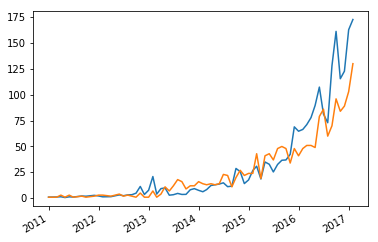

In [17]:
predictions_ARIMA.plot()
train_data[1:].plot()

In [18]:

x = train_data.index[-18:]
x = x.shift(19, freq='M')
x = x.to_period('M').to_timestamp()
pred_Series = model.predict(train_data.shape[0], train_data.shape[0]+17).values
pred_Series = pd.Series(pred_Series, index=x)
#predictions_diff = predictions_diff.append(pred_Series);

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [19]:
pred_Series = model.fittedvalues.append(pred_Series)

step_preds_diff_cumsum = pred_Series.cumsum()
step_preds_diff_log = pd.Series(train_data_logs.iloc[0], index=pred_Series.index)
step_preds_diff_log = step_preds_diff_log[:].add(step_preds_diff_cumsum.values)
step_preds_ARIMA = np.exp(step_preds_diff_log)

In [20]:
len(train_data)

70

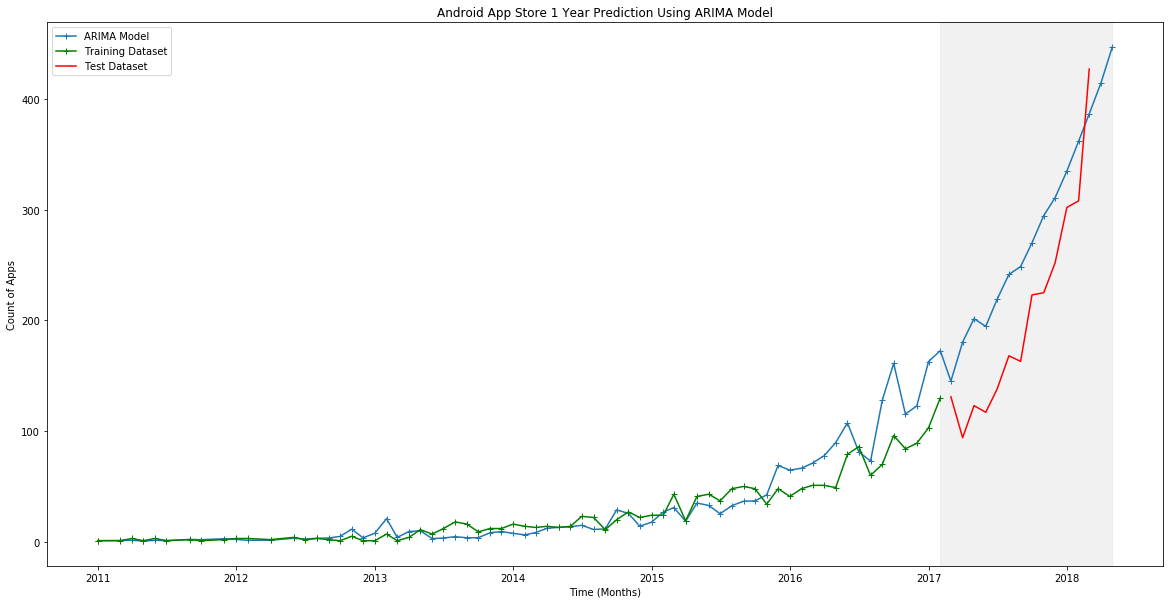

In [27]:
fig2 = plt.figure(figsize=(20,10))
plt.title(label='Android App Store 1 Year Prediction Using ARIMA Model')
plt.plot(step_preds_ARIMA[:-3], marker='+', label='ARIMA Model')
plt.plot(train_data[1:], color='g', marker='+', label='Training Dataset')
plt.plot(test_data[:-5], color='r', label='Test Dataset')
plt.axvspan(train_data.index[-1], step_preds_ARIMA.index[-4], alpha=0.3, color='lightgrey')

plt.xlabel(xlabel='Time (Months)')
plt.ylabel(ylabel='Count of Apps')

plt.legend(loc='best')
plt.savefig('ARIMA-preds.png')

In [28]:
def optimize_ARIMA(train_data_transformed):
    pass
    
    